In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom.load(f'{parent}/assets/hand_phantom')

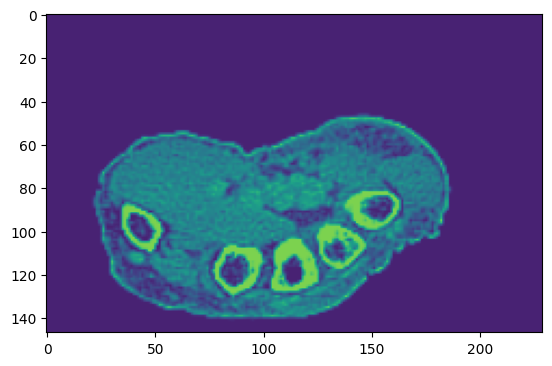

In [3]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)

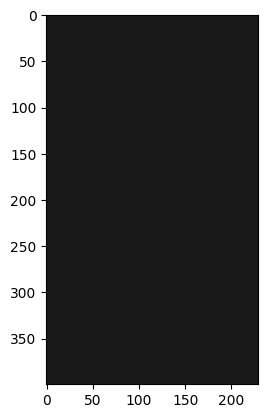

In [14]:
# for i in range(0,test_phantom.get_complete().shape[1],2):
#     plt.imshow(test_phantom.get_complete()[0, i, :, ::-1].T, vmin=1500, vmax=2000, cmap='gray')
#     plt.savefig(f'video/hand_phantom_{str(i).zfill(3)}.png', dpi=150)

In [5]:
z_heights = np.arange(-0.09, 0.12, 0.002)

num_transducers = 6
# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 64, 
#                                     width = 60e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/4,
#                                     ray_num = 5, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 60e-3,
#                                     ) for i in range(num_transducers)]

transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 256,
                                    width = 80e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 5, 
                                    imaging_ndims = 2,
                                    focus_elevation = 60e-3,
                                    ) for i in range(num_transducers * len(z_heights))]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
for i in range(len(z_heights)):
    rotations = [geometry.Transform((r,0,0),(0,0,0)) for r in np.linspace(0, 2 * np.pi, num_transducers, endpoint=False)]
    positions = [rot.apply_to_point((-0.07,0,z_heights[i])) for rot in rotations]
    for j in range(num_transducers):
        rotations[j].translation = positions[j]
        test_transducer_set.assign_pose(i * num_transducers + j, rotations[j])

In [7]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

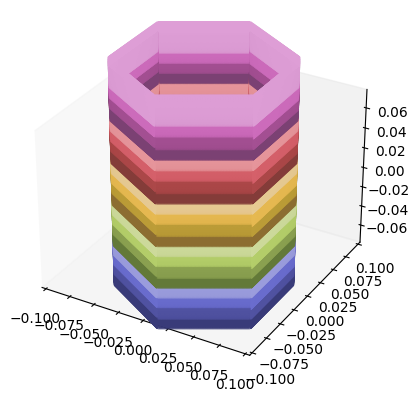

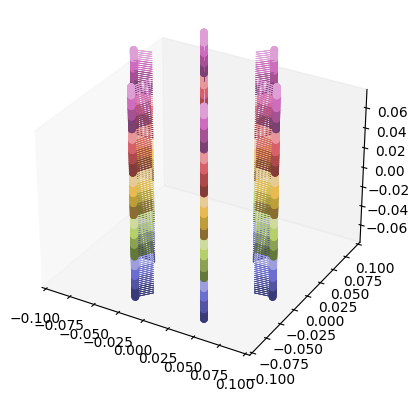

In [8]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [9]:
# simprops = simulation.SimProperties(
#                 grid_size   = (90e-3,20e-3,20e-3),
#                 voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
#                 PML_size    = (32,8,8),
#                 PML_alpha   = 2,
#                 t_end       = 12e-5,           # [s]
#                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
#                 alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
#                 alpha_power = 1.5,
#                 grid_lambda = 2,               # 
#                 )

simprops = simulation.SimProperties(
                grid_size   = (100e-3,100e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [10]:
test_experiment = experiment.Experiment(
                 simulation_path = f'invitro_arm_experiment_1mhz_3D',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


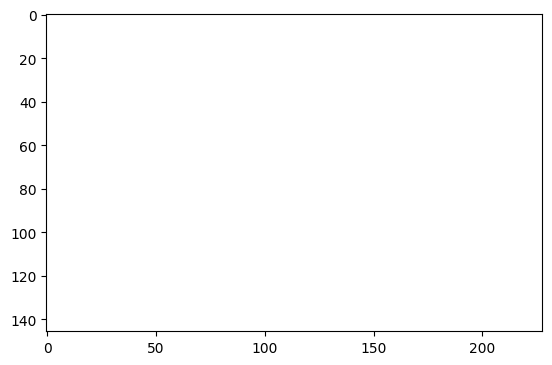

In [11]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_experiment.phantom.mask.shape[2]//2])

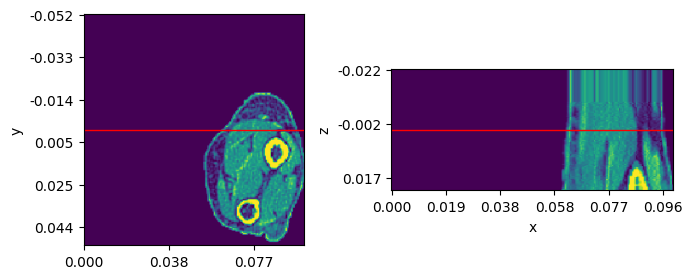

In [12]:
test_experiment.plot_ray_path(0)

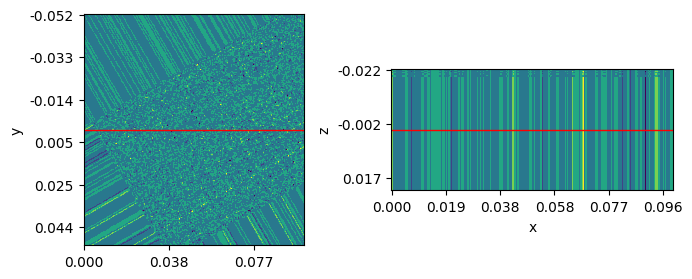

In [13]:
test_experiment.plot_ray_path(len(test_experiment)-1)

In [14]:
len(test_experiment)

3150

In [15]:
test_experiment = experiment.Experiment.load('invitro_arm_experiment_1mhz_3D')
test_experiment.run(dry=True)

Number of simulation results (3000) is less than the expected number of simulation results (3150), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 630/630 [02:27<00:00,  4.27it/s]


In [16]:
test_experiment.run(repeat=False)

running with 5 workers

preparation for sim 3000 completed in 19.89 seconds
preparation for sim 3038 completed in 19.92 seconds
preparation for sim 3076 completed in 19.71 seconds
preparation for sim 3113 completed in 19.69 seconds
preparation for sim 3001 completed in 36.52 seconds
preparation for sim 3039 completed in 36.74 seconds
preparation for sim 3077 completed in 36.09 seconds
simulation          3000 completed in 32.97 seconds
simulation          3038 completed in 33.29 seconds
simulation          3076 completed in 33.62 seconds
preparation for sim 3002 completed in 20.63 seconds
preparation for sim 3078 completed in 21.39 seconds
preparation for sim 3114 completed in 21.24 seconds
preparation for sim 3040 completed in 20.77 seconds
simulation          3113 completed in 34.78 seconds
simulation          3001 completed in 33.53 seconds
simulation          3039 completed in 33.59 seconds
simulation          3077 completed in 33.37 seconds
preparation for sim 3115 completed in 20

In [17]:
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(test_experiment)

In [18]:
len(z_heights)

105

In [19]:
for i in range(len(z_heights)):
    if i < 98:
        continue
    image = test_reconstruction.selective_compound(workers=30, transducers=[i*6,i*6+1,i*6+2,i*6+3,i*6+4,i*6+5], resolution_multiplier=2, local=True, combine=True)
    # utils.save_array(image, f'invitro_arm_experiment_1mhz_3D/images/compounded_image_{i}.npy')
    break

100%|██████████| 3150/3150 [00:00<00:00, 2152502.05it/s]

running reconstruction on 30 rays


In [20]:
print(image.shape)

(191, 298, 1)


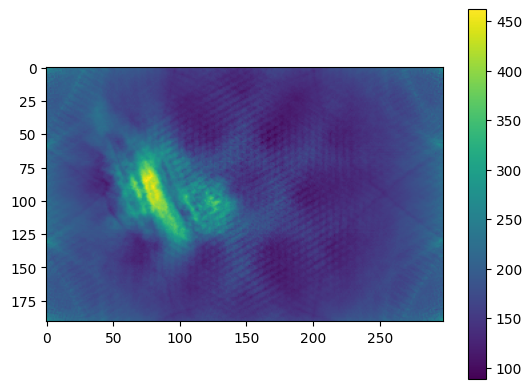

In [21]:
plt.imshow(image[:, :,0])
plt.colorbar()

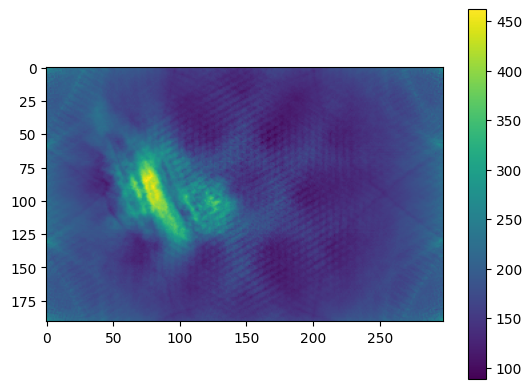

: 

In [22]:
plt.imshow(image[:, :,0])
plt.colorbar()

In [23]:
images = test_reconstruction.selective_compound(workers=30, transducers=[60,61,62,63,64,65], resolution_multiplier=2, local=True, combine=True)

100%|██████████| 3150/3150 [00:00<00:00, 2116638.51it/s]

running reconstruction on 30 rays


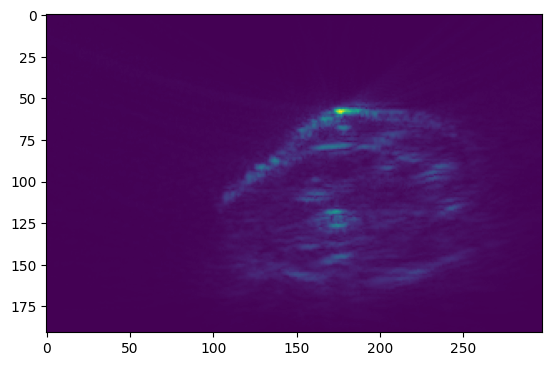

In [ ]:
plt.imshow(images[:,:,0])

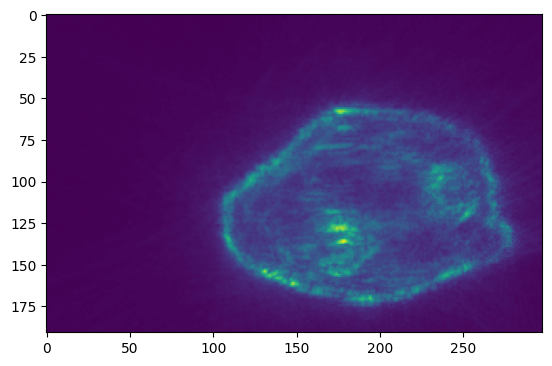

In [ ]:
plt.imshow(images[:,:,0])

In [ ]:
images = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 30/30 [00:00<00:00, 699050.67it/s]


In [ ]:
for image in images:
    plt.xticks(np.linspace(0, image.shape[1],9))
    plt.yticks(np.linspace(0, image.shape[0],9))
    plt.imshow(image[:,:,image.shape[2]//2])
    plt.grid(color='w', linestyle='-', linewidth=0.1)
    plt.show()

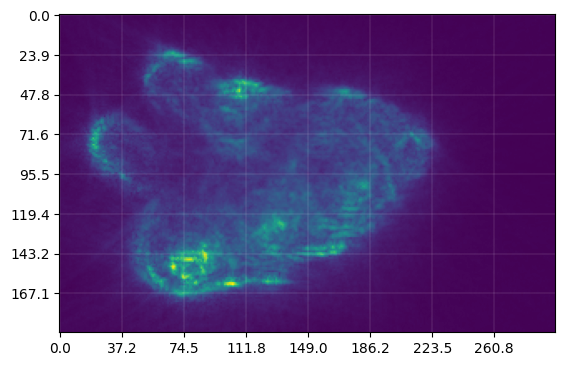

In [ ]:
plt.xticks(np.linspace(0, image.shape[1],9))
plt.yticks(np.linspace(0, image.shape[0],9))
plt.imshow(np.sum(images, axis=0)[:,:,image.shape[2]//2])
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

In [2]:
import natsort

In [3]:
slices = natsort.natsorted(glob.glob('invitro_arm_experiment_1mhz_3D/images/*.npz'))
arr = []
for im in slices:
    arr.append(utils.load_array(im))

image = np.concatenate(arr, axis=-1)

# image = np.repeat(image, 5, axis=-1)

In [4]:
image.shape

(191, 298, 100)

In [5]:
from scipy.interpolate import RegularGridInterpolator

In [6]:
x = np.arange(0, image.shape[0])
y = np.arange(0, image.shape[1])
z = np.arange(0, image.shape[2])
interp = RegularGridInterpolator((x, y, z), image)

In [7]:
phantom_matrix = utils.load_array('invitro_arm_experiment_1mhz_3D/phantom/complete.npy')

xp = np.linspace(0, image.shape[0]-1, phantom_matrix.shape[1])
yp = np.linspace(0, image.shape[1]-1, phantom_matrix.shape[2])
zp = np.linspace(0, image.shape[2]-1, phantom_matrix.shape[3])
pts = np.array(np.meshgrid(xp, yp, zp, indexing='ij')).T.reshape(-1, 3)
scaled_image = interp(pts)

In [12]:
scaled_image = scaled_image.reshape(phantom_matrix.shape[3], phantom_matrix.shape[2], phantom_matrix.shape[1]).transpose(2,1,0)

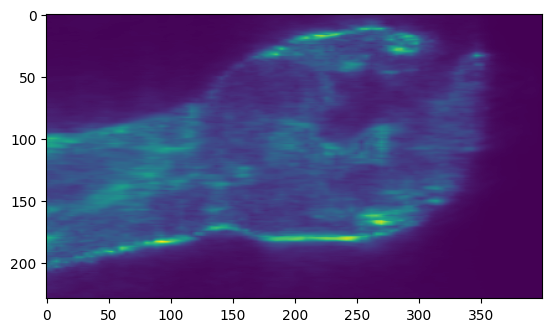

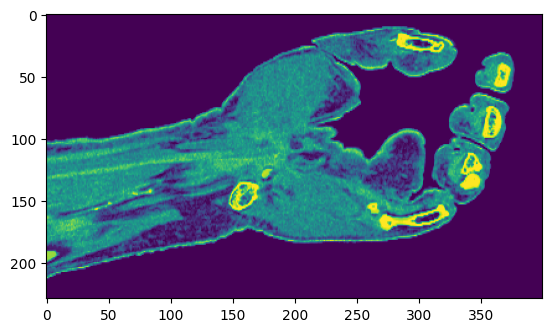

In [9]:
index = 70
plt.imshow(scaled_image[index,:,:])
plt.show()
plt.imshow(phantom_matrix[0,index,:,:])
plt.show()

In [14]:
from PIL import Image

In [22]:
rescaled_image = scaled_image * 2

for index in range(0,400,16):
    Image.fromarray(rescaled_image[:,:,index].astype(np.uint16), ).save(f'arm_tomography_{index}.png')
    # plt.imshow(scaled_image[:,:,index], vmin=0, vmax=20000, cmap='gray')
    # plt.gca().set_facecolor('black')
    # plt.gca().set_xticks([])
    # plt.gca().set_yticks([])
    # plt.savefig(f'arm_tomography_{index}.png', bbox_inches='tight', pad_inches=0, dpi=600)

In [10]:
len(range(0,400,16))

25

In [24]:
utils.save_mrc(rescaled_image, 'invitro_arm_experiment_1mhz_3D/compounded_image.mrc')

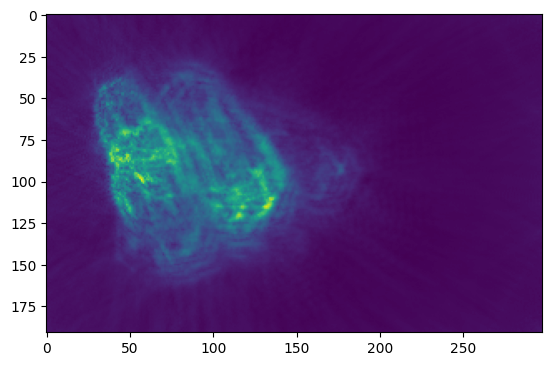

In [ ]:
plt.imshow(image[:,:,-1])

In [ ]:
image.shape

(191, 298, 360)